In [2]:
import gluonts
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq="5min", 
                            prediction_length=36, 
                            trainer=Trainer(epochs=10))

INFO:root:Using CPU
INFO:root:Using CPU


In [4]:
load_data = False

In [5]:
if load_data:
    url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
    df = pd.read_csv(url, header=0, index_col=0)
    df.to_csv("./data/Twitter_volume_AMZN.csv")

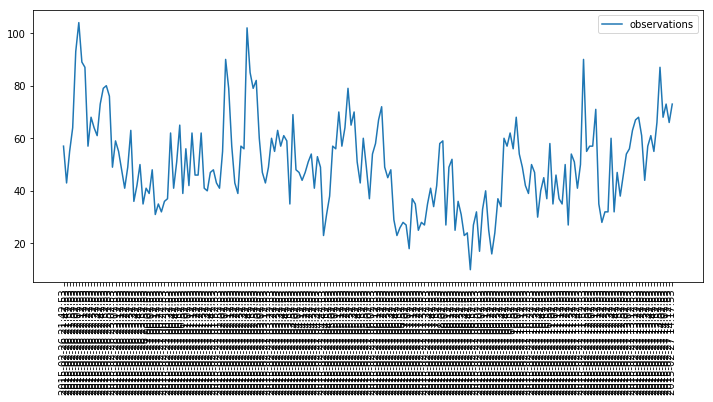

In [6]:
df = pd.read_csv("./data/Twitter_volume_AMZN.csv")

plt.figure(1, figsize=(12, 5))
plt.plot(df["timestamp"][:200], df["value"][:200])
plt.xticks(rotation="vertical")
plt.legend(["observations"])
plt.show()

In [7]:
df.head(2)

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43


In [8]:
from gluonts.dataset.common import ListDataset

df.index = df["timestamp"]

training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)

In [9]:
predictor = estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.00it/s, avg_epoch_loss=4.39]
INFO:root:Epoch[0] Elapsed time 8.334 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.394904
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.23it/s, avg_epoch_loss=4.06]
INFO:root:Epoch[1] Elapsed time 8.021 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.064922
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.46it/s, avg_epoch_loss=4.02]
INFO:root:Epoch[2] Elapsed time 9.150 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.022505
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.16it/s, avg_epoch_loss=4]
INFO:root:Epoch[3] Elapsed time 9.683 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.996620
INFO:root:Epoch[4] Learning rate is 0.001
100

In [10]:
test_data = ListDataset(
    [
        {"start": df.index[0], "target": df.value[:"2015-04-10 03:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-15 18:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-20 12:00:00"]}
    ],
    freq = "5min"
)

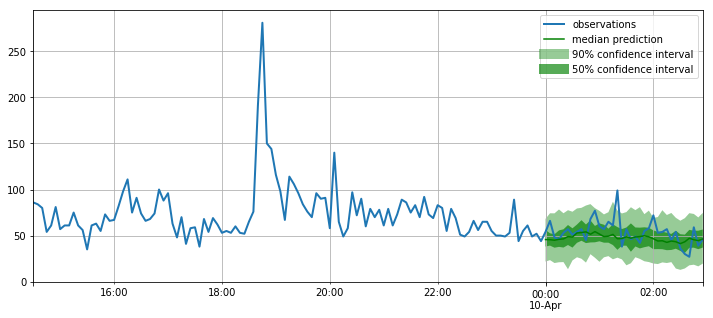

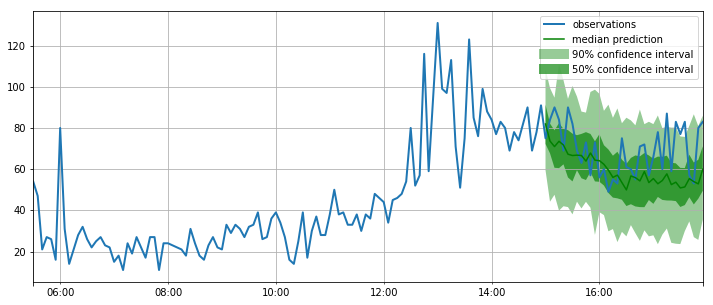

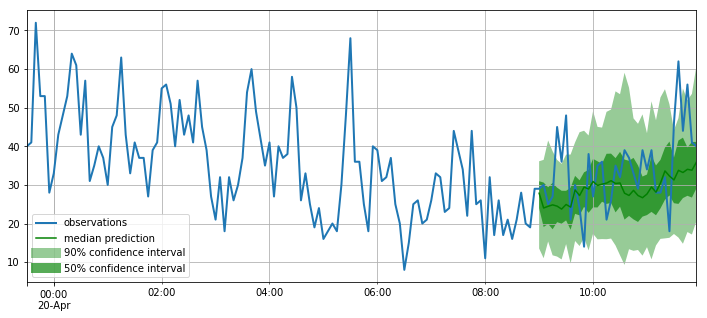

In [11]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

In [12]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5], seasonality=2016)

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
agg_metrics

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 207.89it/s]


{'MSE': 170.05270046657984,
 'abs_error': 1079.9232177734375,
 'abs_target_sum': 5658.0,
 'abs_target_mean': 52.38888888888889,
 'seasonal_error': 18.833625618877182,
 'MASE': 0.5305071265821981,
 'sMAPE': 0.20394360966056693,
 'MSIS': 21.22028554205438,
 'QuantileLoss[0.5]': 1079.9232292175293,
 'Coverage[0.5]': 0.2777777777777778,
 'RMSE': 13.040425624441092,
 'NRMSE': 0.24891586557787873,
 'ND': 0.19086659911160084,
 'wQuantileLoss[0.5]': 0.1908666011342399,
 'mean_wQuantileLoss': 0.1908666011342399,
 'MAE_Coverage': 0.2222222222222222}

# Compare to naïve model

In [13]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="5min", prediction_length=36, season_length=12*24*7)

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=seasonal_predictor_1W, num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)

agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics, orient='index').rename(columns={0: "DeepAR"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"})
)
df_metrics.loc[["MASE", "sMAPE", "RMSE"]]

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 180.35it/s]


,DeepAR,Seasonal naive
MASE,0.530507,1.024993
sMAPE,0.203944,0.341459
RMSE,13.040426,28.481475


In [15]:
forecast = forecasts[0]

In [16]:
forecast

SampleForecast(array([[49., 61., 46., 44., 36., 64., 64., 45., 65., 53., 67., 49., 53.,
        51., 52., 41., 44., 53., 43., 66., 88., 57., 68., 47., 48., 35.,
        36., 62., 54., 72., 70., 66., 61., 65., 60., 62.]], dtype=float32)), Timestamp('2015-04-10 00:00:00', freq='5T'), '5T', item_id=None, info=None)

In [17]:
len(forecasts)

3

In [18]:
dir(forecast)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dim',
 '_index',
 '_mean',
 '_sorted_samples',
 '_sorted_samples_value',
 'as_json_dict',
 'copy_dim',
 'dim',
 'freq',
 'index',
 'info',
 'item_id',
 'mean',
 'mean_ts',
 'num_samples',
 'plot',
 'prediction_length',
 'quantile',
 'samples',
 'start_date']

In [21]:
forecast.samples

array([[49., 61., 46., 44., 36., 64., 64., 45., 65., 53., 67., 49., 53.,
        51., 52., 41., 44., 53., 43., 66., 88., 57., 68., 47., 48., 35.,
        36., 62., 54., 72., 70., 66., 61., 65., 60., 62.]], dtype=float32)

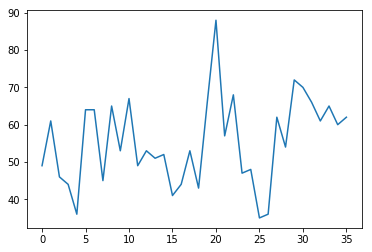

In [24]:
plt.plot(forecast.samples[0])

In [25]:
forecast.__dict__

{'samples': array([[49., 61., 46., 44., 36., 64., 64., 45., 65., 53., 67., 49., 53.,
         51., 52., 41., 44., 53., 43., 66., 88., 57., 68., 47., 48., 35.,
         36., 62., 54., 72., 70., 66., 61., 65., 60., 62.]], dtype=float32),
 '_sorted_samples_value': array([[49., 61., 46., 44., 36., 64., 64., 45., 65., 53., 67., 49., 53.,
         51., 52., 41., 44., 53., 43., 66., 88., 57., 68., 47., 48., 35.,
         36., 62., 54., 72., 70., 66., 61., 65., 60., 62.]], dtype=float32),
 '_mean': None,
 '_dim': None,
 'item_id': None,
 'info': None,
 'start_date': Timestamp('2015-04-10 00:00:00', freq='5T'),
 'freq': '5T',
 '_index': DatetimeIndex(['2015-04-10 00:00:00', '2015-04-10 00:05:00',
                '2015-04-10 00:10:00', '2015-04-10 00:15:00',
                '2015-04-10 00:20:00', '2015-04-10 00:25:00',
                '2015-04-10 00:30:00', '2015-04-10 00:35:00',
                '2015-04-10 00:40:00', '2015-04-10 00:45:00',
                '2015-04-10 00:50:00', '2015-04-10 00:5

In [26]:
test_data.__dict__

{'list_data': [{'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
   'target': array([57., 43., 55., ..., 59., 39., 46.], dtype=float32),
   'source': SourceContext(source='list_data', row=1)},
  {'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
   'target': array([57., 43., 55., ..., 53., 80., 83.], dtype=float32),
   'source': SourceContext(source='list_data', row=2)},
  {'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
   'target': array([57., 43., 55., ..., 56., 41., 40.], dtype=float32),
   'source': SourceContext(source='list_data', row=3)}]}

In [27]:
df.index[0]

'2015-02-26 21:42:53'